# Quantum Efficiency Analysis Workbook

Import Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import scipy
from integrating_sphere_funcs import sphere_flux_correction
from cosmos_helper_funcs import label_plot, get_stacks, cosmos_gain_dict
global c
c = 2.998 * 10 ** 10 # speed of light in cm/s
global h
h = 6.626 * 10 ** -27 # Planck's constant in g cm^2/s
this_dir = os.getcwd()

Create a class representing a calibrated photodiode with its associated response curve.

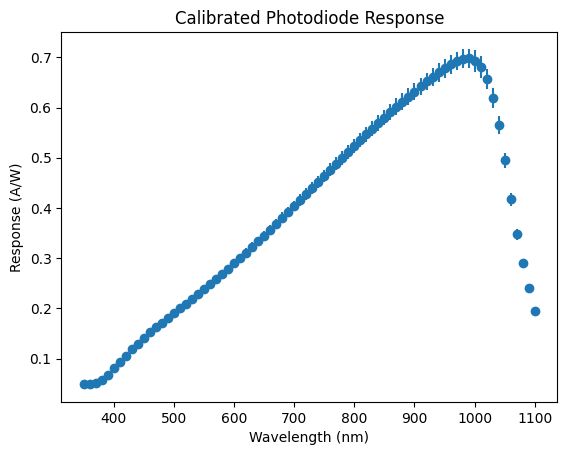

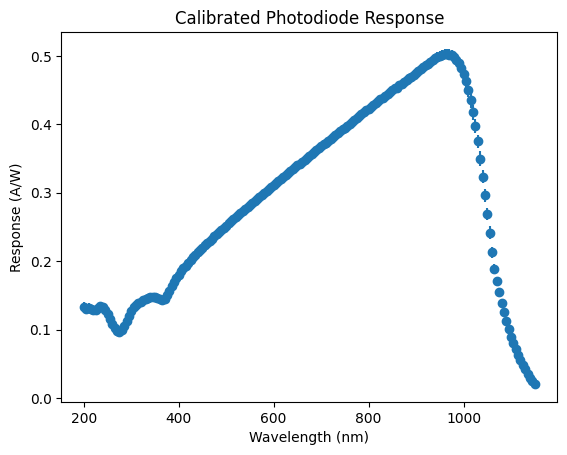

In [2]:
class CalibratedPD(object):
    '''A class to represent a calibrated photodiode.
    
    Attributes:
    ------------
    filename : str
        The complete path to the FITS or csv file containing the calibrated
        photodiode response. The data should have three columns:
        wavelength (nm), response (A/W), and uncertainty in response
        (percent).
    response : numpy.ndarray
        The calibrated photodiode response. First column is
        wavelength in nm, second column is response in A/W. Third
        column is uncertainty in response, in percent.
    area : float
        The area of the photodiode active area, in cm^2.
    plot : bool
        If True, a plot of the response will be generated.
    '''
    def __init__(self, filename, area, plot=False):
        if filename.endswith('.fits'):
            self.response = fits.getdata(filename)
        elif filename.endswith('.csv'):
            self.response = np.genfromtxt(filename, delimiter=',')
        self.area = area
        self.plot = plot
        if plot:
            self.plot_response()

    def plot_response(self):
        '''Plot the calibrated photodiode response.'''
        fig, ax = plt.subplots()
        errors = self.response[:,2] * self.response[:,1] / 100
        ax.errorbar(self.response[:,0], self.response[:,1],
                    yerr=errors, fmt='o')
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Response (A/W)')
        ax.set_title('Calibrated Photodiode Response')
        plt.show()

    def get_response(self, wavelength):
        '''Returns the calibrated photodiode response at a given wavelength.'''
        response = np.interp(wavelength, self.response[:,0], self.response[:,1])
        return response
    
data_dir = this_dir + '/data/'
thorlabs_filename = os.path.join(data_dir, 'ThorLabsPD.csv')
hamamatsu_filenmae = os.path.join(data_dir, 'HamamatsuPD.csv')
thorlabs_pd = CalibratedPD(thorlabs_filename, 1, plot=True)
hamamatsu_pd = CalibratedPD(hamamatsu_filenmae, 1, plot=True)

Create a class to input data from exposures at different wavelengths and calculate the QE. It also includes a method to estimate the depletion depth.

In [ ]:
class QECalc(object):

    def __init__(self, wavelengths, exp_times, pd_dark_vals, pd_gray_vals,
                 img_dark_vals, img_gray_vals, pix_area, gain, pd,
                 pd_pos=np.array([1,1]), sensor_pos=np.array([1,1]), sensor_size=0,
                 int_sphere_port=4):
        '''Initializes the QECalc object with the necessary data to calculate the QE of the camera.

        Parameters:
        ----------
        wavelengths : numpy.ndarray
            The wavelength for each exposure, in nm.
        exp_times : numpy.ndarray
            The exposure time for each wavelength value, in s. For each wavelength value,
            two exposures are taken at the corresponding exposure time: one with the
            shutter closed and one with the shutter open.
        pd_dark_vals : numpy.ndarray
            The average current measured by the calibrated photodiode for each exposure
            with the shutter closed, in A.
        pd_gray_vals : numpy.ndarray
            The average current measured by the calibrated photodiode for each exposure
            with the shutter open, in A.
        img_dark_vals : numpy.ndarray
            The average pixel value for each exposure with the shutter closed.
        img_gray_vals : numpy.ndarray
            The average pixel value for each exposure with the shutter open.
        pix_area : float
            The area of each pixel in the camera, in cm^2.
        gain : float
            The gain of the camera, in ADU/e-.
        pd: CalibratedPD object
            The calibrated photodiode object used to calculate photon flux.
        pd_pos : numpy.ndarray (optional, default=[1,1])
            The position of the photodiode relative to the integrating sphere port.
            First entry is r, second entry is d. Units must be consistent with
            sensor_pos, sensor_size, and int_sphere_port.
        sensor_pos : numpy.ndarray (optional, default=[1,1])
            The position of the camera sensor relative to the integrating sphere port.
            First entry is r, second entry is d.
        sensor_size : float (optional, default=0)
            The width of the camera sensor. Assumes sensor is square.
        int_sphere_port : int (optional, default=4)
            The diameter of the integrating sphere port.
        '''
        self.wavelengths = wavelengths
        self.exp_times = exp_times
        self.pd_dark_vals = pd_dark_vals
        self.pd_gray_vals = pd_gray_vals
        self.img_dark_vals = img_dark_vals
        self.img_gray_vals = img_gray_vals
        self.pix_area = pix_area
        self.gain = gain
        self.pd = pd
        self.pd_pos = pd_pos
        self.sensor_pos = sensor_pos
        self.sensor_size = sensor_size
        self.int_sphere_port = int_sphere_port
        self.flux_corr = self.get_flux_correction()
        self.qe_vals = self.get_qe_vals()
        # self.depl_depth = self.get_depl_depth()

    def add_points(self, wavelengths, exp_times, pd_dark_vals, pd_gray_vals,
                    img_dark_vals, img_gray_vals):
        '''Adds additional data points to the QECalc object.'''
        self.wavelengths = np.append(self.wavelengths, wavelengths)
        self.exp_times = np.append(self.exp_times, exp_times)
        self.pd_dark_vals = np.append(self.pd_dark_vals, pd_dark_vals)
        self.pd_gray_vals = np.append(self.pd_gray_vals, pd_gray_vals)
        self.img_dark_vals = np.append(self.img_dark_vals, img_dark_vals)
        self.img_gray_vals = np.append(self.img_gray_vals, img_gray_vals)
        self.qe_vals = self.get_qe_vals()
        # self.depl_depth = self.get_depl_depth()

    def add_qe_points(self, wavelengths, qe_vals):
        '''Adds additional QE data points to the QECalc object.'''
        self.wavelengths = np.append(self.wavelengths, wavelengths)
        self.qe_vals = np.append(self.qe_vals, qe_vals)
        self.exp_times = np.append(self.exp_times, np.zeros_like(wavelengths) * np.NaN)
        self.pd_dark_vals = np.append(self.pd_dark_vals, np.zeros_like(wavelengths) * np.NaN)
        self.pd_gray_vals = np.append(self.pd_gray_vals, np.zeros_like(wavelengths) * np.NaN)
        self.img_dark_vals = np.append(self.img_dark_vals, np.zeros_like(wavelengths) * np.NaN)
        self.img_gray_vals = np.append(self.img_gray_vals, np.zeros_like(wavelengths) * np.NaN)
        # self.depl_depth = self.get_depl_depth()

    def get_flux_correction(self):
        '''Find correction factor for PD and sensor being at different positions relative to sphere.'''
        flux_corr = sphere_flux_correction(self.int_sphere_port, self.pd_pos[0], self.pd_pos[1],
                                           self.sensor_pos[0], self.sensor_pos[1], self.sensor_size)
        return flux_corr

    def get_qe_vals(self):
        '''Calculates the quantum efficiencies of the camera at each wavelength.'''
        qe_vals = np.zeros_like(self.pd_dark_vals)
        for i, wavelength in enumerate(self.wavelengths):
            pd_response = self.pd.get_response(wavelength)
            # Get the photon energy rate, in ergs/s
            phot_energy_rate = (self.pd_gray_vals[i] - self.pd_dark_vals[i]) / pd_response * 10 ** 7
            phot_energy = h * c / (wavelength * 10 ** -7)
            # Get the absolute photon flux, in phot/s/cm^2
            abs_phot_flux = phot_energy_rate / phot_energy / self.pd.area * self.flux_corr
            # Get the number of photons collected at the sensor per pixel per second
            img_phot_pix = (self.img_gray_vals[i] - self.img_dark_vals[i]) / self.gain / self.exp_times[i]
            qe_vals[i] = img_phot_pix / self.pix_area / abs_phot_flux
        return qe_vals
    
    def interp_qe(self, wavelength):
        '''Interpolates the quantum efficiency of the camera at a given wavelength.'''
        qe = np.interp(wavelength, self.wavelengths, self.qe_vals)
        return qe
    
    def get_depl_depth(self):
        '''Estimates the sensor depletion depth by fitting to silicon absorption.'''
        dir = os.path.abspath('')
        silicon_abs = np.genfromtxt(dir + '/data/silicon_absorption.csv', delimiter=',')
        def theoretical_qe(wavelength, depletion_depth, max_qe=1):
            '''Returns the theoretical quantum efficiency of silicon at a given wavelength'''
            abs_length = np.interp(wavelength, silicon_abs[:, 0], silicon_abs[:, 1])
            return (1 - np.exp(-depletion_depth / abs_length)) * max_qe
        fit_cut_on_wavelength = 600
        wavelength_arr = self.wavelengths[self.wavelengths > fit_cut_on_wavelength]
        qe_arr = self.qe_vals[self.wavelengths > fit_cut_on_wavelength]
        if len(wavelength_arr) < 5:
            raise ValueError('Not enough data points >600 nm to fit to silicon absorption.')
        popt, pcov = scipy.optimize.curve_fit(theoretical_qe, wavelength_arr, qe_arr, p0=[10, 1])
        return popt
    
    def plot_qe(self):
        '''Plots the quantum efficiency of the camera as a function of wavelength.'''
        plt.scatter(self.wavelengths, self.qe_vals)
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Quantum Efficiency')
        plt.ylim(0, 1)
        plt.show()


Dictionary relating filter number to wavelength

In [4]:
filter_dict = {'1A': 640, '2A': 700, '3A': 750, '4A': 800, '5A': 830, '6A': 850, '7A': 880, '8A': 905,
               '9A': 950, '10A': 980, '11A': 1000, '12A': 1064, '1B': 200, '2B': 250, '3B': 297,
                '4B': 350, '5B': 400, '6B': 450, '7B': 500, '8B': 550, '9B': 600, '10B': 440}

In [5]:
# Get defect pixel maps
defect_file_calibration = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Final Data Products/Calibration/Defect Maps/defect_map_calibration_HSHGRS.fits'
defect_file_dark = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Final Data Products/Calibration/Defect Maps/defect_map_dark_HSHGRS.fits'
defect_map_calibration = fits.getdata(defect_file_calibration)
defect_map_dark = fits.getdata(defect_file_dark)
defect_map_total = defect_map_calibration * defect_map_dark
print(defect_map_total)

[[ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [6]:
# Load stacks1 for HSHGRS QE measurement
data_folder1 = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_RS/ThorLabs PD'
stacks1 = get_stacks(data_folder1)

# From baseFileName for each stack, extract the filter name
filters1 = []

dark_stacks1 = [stack for stack in stacks1 if stack['baseFileName'].split('_')[5] == 'SC']
gray_stacks1 = [stack for stack in stacks1 if stack['baseFileName'].split('_')[5] == 'SO']
gray_vals1 = np.zeros(len(gray_stacks1))
dark_vals1 = np.zeros(len(gray_stacks1))
exp_times1 = np.zeros(len(gray_stacks1))
for i, stack in enumerate(gray_stacks1):
    filter = stack['baseFileName'].split('_')[6].split(' ')[0]
    # Find the dark stack with the same filter
    dark_stack = [dark_stack for dark_stack in dark_stacks1 if dark_stack['baseFileName'].split('_')[6].split(' ')[0] == filter][0]
    dark_frames = dark_stack['imagestack'] * defect_map_total
    gray_frames = stack['imagestack'] * defect_map_total
    mean_gray_val = np.nanmean(gray_frames)
    mean_dark_val = np.nanmean(dark_frames)
    exp_time = int(stack['exposure_ms']) / 1000
    filters1.append(filter[1:])
    gray_vals1[i] = mean_gray_val
    dark_vals1[i] = mean_dark_val
    exp_times1[i] = exp_time
    print(f'Filter: {filter}, Gray: {mean_gray_val}, Dark: {mean_dark_val}, Exp Time: {exp_time}')
wavelengths1 = np.array([filter_dict[filter] for filter in filters1])
# Sort all arrays by wavelength
sort_idx = np.argsort(wavelengths1)
wavelengths1 = wavelengths1[sort_idx]
exp_times1 = exp_times1[sort_idx]
dark_vals1 = dark_vals1[sort_idx]
gray_vals1 = gray_vals1[sort_idx]


Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_RS/ThorLabs PD/calibrated_HighHighG_RS_raw_4500ms_SO_F10A 2024 May 07 14_43_38.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_RS/ThorLabs PD/calibrated_HighHighG_RS_raw_2500ms_SO_F7B 2024 May 07 14_38_51.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_RS/ThorLabs PD/calibrated_HighHighG_RS_raw_2500ms_SO_F8B 2024 May 07 14_40_25.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_RS/ThorLabs PD/calibrated_HighHighG_RS_raw_2500ms_SC_F9B 2024 May 07 14_42_26.fits
Now rea

In [7]:
print(wavelengths1)
pix_area = 10 ** -6
gain1 = 1.041
pd_dark_vals1 = 10 ** -13 * np.array([-1, -0.5, -0.5, -0.5, -1, -1 -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
pd_gray_vals1 = 10 ** -10 * np.array([0.266, 0.753, 2.54, 3.34, 4.05, 4.20, 6.48, 5.37, 6.33, 6.34, 7.33, 8.21, 10.1, 12.6, 8.93, 20.9, 27.1, 1.82])
cosmosQE1 = QECalc(wavelengths1, exp_times1, pd_dark_vals1, pd_gray_vals1,
                  dark_vals1, gray_vals1, pix_area, gain1, thorlabs_pd,
                  pd_pos=np.array([32.0, 1.5]), sensor_pos=np.array([32.67 + 5/16,0]),
                  sensor_size=3.19, int_sphere_port=4)
# cosmosQE1.plot_qe()

[ 350  400  450  500  550  600  640  700  750  800  830  850  880  905
  950  980 1000 1064]
350 444.34493485947326 904287366.1848464
400 1185.55125150043 1764336695.0356395
450 3034.169879675188 3844464350.119105
500 3605.975591346951 4168224645.610753
550 3841.1414280782 4438857603.498892
600 3628.8969474918886 4122233024.248132
640 4865.760590349205 5888419826.121481
700 3252.9893510545317 4412605123.765373
750 3103.474917372983 4852201570.03267
800 2445.8052780028543 4599062260.837063
830 2382.5310770743945 5170473904.866423
850 2347.7176362791574 5705716931.9741
880 2283.31325486671 6886822009.83233
905 2418.316541860658 8488625934.619253
950 1155.1800941407162 5933585960.932587
980 2007.6662695366476 13934250076.649332
1000 2135.1922824199446 18542800220.1608
1064 68.15418618776438 2359276621.555637


In [8]:
data_folder2 = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_RS/Hamamatsu PD'
stacks2 = get_stacks(data_folder2)
# From baseFileName for each stack, extract the filter name
filters2 = []

dark_stacks2 = [stack for stack in stacks2 if stack['baseFileName'].split('_')[5] == 'SC']
gray_stacks2 = [stack for stack in stacks2 if stack['baseFileName'].split('_')[5] == 'SO']
gray_vals2 = np.zeros(len(gray_stacks2))
dark_vals2 = np.zeros(len(gray_stacks2))
exp_times2 = np.zeros(len(gray_stacks2))
for i, stack in enumerate(gray_stacks2):
    filter = stack['baseFileName'].split('_')[6].split(' ')[0]
    # Find the dark stack with the same filter
    dark_stack = [dark_stack for dark_stack in dark_stacks2 if dark_stack['baseFileName'].split('_')[6].split(' ')[0] == filter][0]
    dark_frames = dark_stack['imagestack'] * defect_map_total
    gray_frames = stack['imagestack'] * defect_map_total
    mean_gray_val = np.nanmean(gray_frames)
    mean_dark_val = np.nanmean(dark_frames)
    exp_time = int(stack['exposure_ms']) / 1000
    filters2.append(filter[1:])
    gray_vals2[i] = mean_gray_val
    dark_vals2[i] = mean_dark_val
    exp_times2[i] = exp_time
    print(f'Filter: {filter}, Gray: {mean_gray_val}, Dark: {mean_dark_val}, Exp Time: {exp_time}')
wavelengths2 = np.array([filter_dict[filter] for filter in filters2])
# Sort all arrays by wavelength
sort_idx = np.argsort(wavelengths2)
wavelengths2 = wavelengths2[sort_idx]
exp_times2 = exp_times2[sort_idx]
dark_vals2 = dark_vals2[sort_idx]
gray_vals2 = gray_vals2[sort_idx]

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_RS/Hamamatsu PD/calibrated_HighSHighG_RS_raw_60000ms_SC_F3B 2024 May 08 11_47_19.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_RS/Hamamatsu PD/calibrated_HighSHighG_RS_raw_60000ms_SO_F3B 2024 May 08 11_43_43.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_RS/Hamamatsu PD/calibrated_HighSHighG_RS_raw_2500ms_SC_F9B 2024 May 08 11_32_54.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_RS/Hamamatsu PD/calibrated_HighSHighG_RS_raw_2500ms_SO_F9B 2024 May 08 11_32_41.fit

In [9]:
print(wavelengths2)
pix_area = 10 ** -6
gain2 = 1.041
pd_dark_vals2 = 10 ** -13 * np.array([2.78, 2.40, 3.25, 4.0, 5.3])
pd_gray_vals2 = 10 ** -12 * np.array([0.567, 2.63, 6.80, 77.3, 466])
cosmosQE2 = QECalc(wavelengths2, exp_times2, pd_dark_vals2, pd_gray_vals2,
                  dark_vals2, gray_vals2, pix_area, gain2, hamamatsu_pd,
                  pd_pos=np.array([32.0 - 0.236, 2.0]), sensor_pos=np.array([32.67 + 1.75,0]),
                  sensor_size=3.19, int_sphere_port=4)
# cosmosQE2.plot_qe()

[200 250 297 350 600]
200 -0.23895591200102337 1871446.1242275857
250 11.892855940517721 20971133.792502288
297 34.10211774206205 67222187.46902783
350 405.5469849393966 784130524.6095856
600 3335.359593904647 3857974621.537802


In [10]:
data_folder3 = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_GS'
stacks3 = get_stacks(data_folder3)
# From baseFileName for each stack, extract the filter name
filters3 = []

dark_stacks3 = [stack for stack in stacks3 if stack['baseFileName'].split('_')[5] == 'SC']
gray_stacks3 = [stack for stack in stacks3 if stack['baseFileName'].split('_')[5] == 'SO']
gray_vals3 = np.zeros(len(gray_stacks3))
dark_vals3 = np.zeros(len(gray_stacks3))
exp_times3 = np.zeros(len(gray_stacks3))
for i, stack in enumerate(gray_stacks3):
    filter = stack['baseFileName'].split('_')[6].split(' ')[0]
    # Find the dark stack with the same filter
    dark_stack = [dark_stack for dark_stack in dark_stacks3 if dark_stack['baseFileName'].split('_')[6].split(' ')[0] == filter][0]
    dark_frames = dark_stack['imagestack'] * defect_map_total
    gray_frames = stack['imagestack'] * defect_map_total
    mean_gray_val = np.nanmean(gray_frames)
    mean_dark_val = np.nanmean(dark_frames)
    exp_time = int(stack['exposure_ms']) / 1000
    filters3.append(filter[1:])
    gray_vals3[i] = mean_gray_val
    dark_vals3[i] = mean_dark_val
    exp_times3[i] = exp_time
    print(f'Filter: {filter}, Gray: {mean_gray_val}, Dark: {mean_dark_val}, Exp Time: {exp_time}')
wavelengths3 = np.array([filter_dict[filter] for filter in filters3])
# Sort all arrays by wavelength
sort_idx = np.argsort(wavelengths3)
wavelengths3 = wavelengths3[sort_idx]
exp_times3 = exp_times3[sort_idx]
dark_vals3 = dark_vals3[sort_idx]
gray_vals3 = gray_vals3[sort_idx]

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_GS/calibrated_HighSHighG_GS_raw_4000ms_SC_F8A 2024 May 07 11_11_33.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_GS/calibrated_HighSHighG_GS_raw_4500ms_SO_F7A 2024 May 07 11_10_56.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_GS/calibrated_HighSHighG_GS_raw_4500ms_SC_F7A 2024 May 07 11_10_34.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_GS/calibrated_HighHighG_GS_raw_2500ms_SO_F8B 2024 May 07 15_11_44.fits
Now reading /Users/layden/Library/CloudStorage/Box-Bo

In [11]:
print(wavelengths3)
pix_area = 10 ** -6
gain3 = 1.052
pd_dark_vals3 = 10 ** -13 * np.array([0, 0, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0])
pd_gray_vals3 = 10 ** -10 * np.array([0.267, 0.752, 2.54, 3.34, 4.05, 4.19, 6.47, 5.37, 6.33, 6.34, 7.33, 8.21, 10.1, 12.6, 8.93, 20.9, 27.1, 1.82])
cosmosQE3 = QECalc(wavelengths3, exp_times3, pd_dark_vals3, pd_gray_vals3,
                  dark_vals3, gray_vals3, pix_area, gain3, thorlabs_pd,
                  pd_pos=np.array([32.0, 1.5]), sensor_pos=np.array([32.67 + 5/16,0]),
                  sensor_size=3.19, int_sphere_port=4)

[ 350  400  450  500  550  600  640  700  750  800  830  850  880  905
  950  980 1000 1064]
350 454.786485860863 904287366.1848464
400 1226.0981805112156 1760824412.2983425
450 3115.814276915496 3845220985.4960217
500 3694.6106501790455 4168848537.9390883
550 3977.9275963704445 4437761859.829797
600 3722.0960190527185 4110460821.4182944
640 5046.777582265031 5879334160.597454
700 3375.3937509284337 4412605123.765373
750 3194.5330097725323 4852201570.03267
800 2538.0733901774274 4599062260.837063
830 2461.702760123194 5170473904.866423
850 2420.806277568356 5705716931.9741
880 2384.480519556751 6886822009.83233
905 2504.640153068482 8488625934.619253
950 1187.3173319257874 5933585960.932587
980 2062.677203946553 13934250076.649332
1000 2215.545636070517 18542116009.237953
1064 68.12339610181103 2357981027.584437


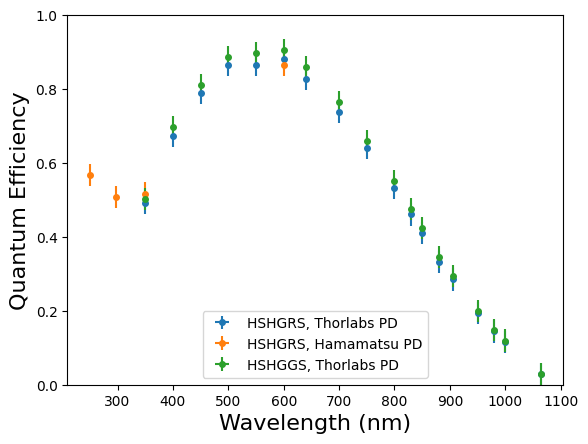

In [19]:
err_wavelength = 0
err_qe = 0.03
# Increase x axis label font size

plt.errorbar(cosmosQE1.wavelengths, cosmosQE1.qe_vals, yerr=err_qe, xerr=err_wavelength, fmt='o', label='HSHGRS, Thorlabs PD', markersize=4)
plt.errorbar(cosmosQE2.wavelengths[1:], cosmosQE2.qe_vals[1:], yerr=err_qe, xerr=err_wavelength, fmt='o', label='HSHGRS, Hamamatsu PD', markersize=4)
# Add a lower limit at 200 nm. Use same color as previous line
# lower_lim_wavelength = 200
# lower_lim_val = 0.21
# plt.hlines(lower_lim_val, lower_lim_wavelength - 10, lower_lim_wavelength + 10, color='C1')
# plt.annotate(
#     '',  # No text for the arrow
#     xy=(lower_lim_wavelength, lower_lim_val - 0.05),  # Arrowhead position (below the limit)
#     xytext=(lower_lim_wavelength, lower_lim_val + 0.005),    # Arrow tail starts at the limit
#     arrowprops=dict(arrowstyle='-|>', color='C1', lw=1.5),
# )
plt.errorbar(cosmosQE3.wavelengths, cosmosQE3.qe_vals, yerr=err_qe, xerr=err_wavelength, fmt='o', label='HSHGGS, Thorlabs PD', markersize=4)
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Quantum Efficiency', fontsize=16)
# I want the legend to just have dots, not errorbar symbols
plt.legend(loc='lower center')
plt.ylim(0,1)
plt.show()

In [ ]:
print(cosmosQE1.wavelengths, cosmosQE1.qe_vals)
print(cosmosQE3.wavelengths, cosmosQE3.qe_vals)

[ 350  400  450  500  550  600  640  700  750  800  830  850  880  905
  950  980 1000 1064] [0.49137581 0.67195295 0.78923085 0.86511066 0.86534459 0.8803231
 0.82632705 0.73720382 0.6396014  0.53180521 0.46079549 0.4114676
 0.33154817 0.28488905 0.19468499 0.1440814  0.1151494  0.02888775]
[ 350  400  450  500  550  600  640  700  750  800  830  850  880  905
  950  980 1000 1064] [0.50292253 0.69632053 0.81030825 0.88624248 0.89638149 0.90551794
 0.85839271 0.76494353 0.65836775 0.55186759 0.47610776 0.42427732
 0.34623815 0.29505837 0.20010114 0.14802929 0.11948721 0.02889056]


: 

In [13]:
# Find the current file's directory
this_dir = os.path.abspath('')
data_folder = this_dir + '/data/'
imx487_arr = np.genfromtxt(data_folder + 'IMX487_QE.csv', delimiter=',')
qcmos_arr = np.genfromtxt(data_folder + 'qCMOS_QE_2.csv', delimiter=',')
cosmos_arr = np.genfromtxt(data_folder + 'cosmos_qe_datasheet.csv', delimiter=',')

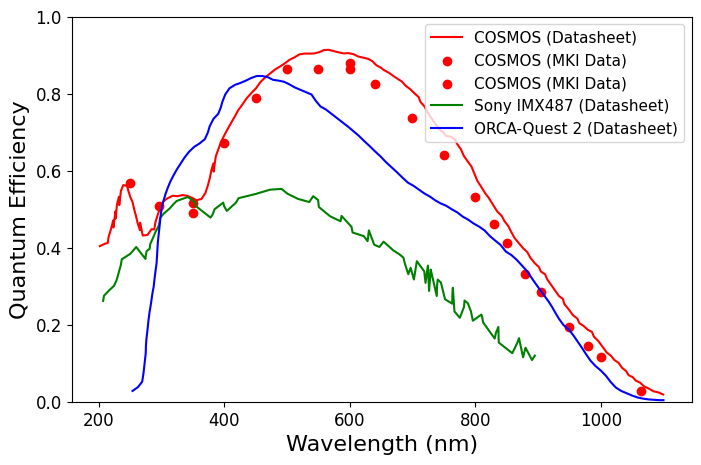

In [14]:
plt.plot(cosmos_arr[:,0], cosmos_arr[:,1], label='COSMOS (Datasheet)', color='red')
plt.scatter(cosmosQE1.wavelengths, cosmosQE1.qe_vals, label='COSMOS (MKI Data)', color='red')
plt.scatter(cosmosQE2.wavelengths[1:], cosmosQE2.qe_vals[1:], label='COSMOS (MKI Data)', color='red')
plt.plot(imx487_arr[:,0], imx487_arr[:,1], label='Sony IMX487 (Datasheet)', color='green')
plt.plot(qcmos_arr[:,0] / 10, qcmos_arr[:,1], label='ORCA-Quest 2 (Datasheet)', color='blue')
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Quantum Efficiency', fontsize=16)
plt.ylim(0, 1.0)
# Make legend have 2 columns
# Put legend above plot
plt.legend(ncol=1, loc='upper right', fontsize=11)
plt.gcf().set_size_inches(8, 5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()